In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_ind, pearsonr
from tqdm import tqdm
from rapidfuzz import fuzz
from operator import itemgetter
from matplotlib import colors

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
DATA_FOLDER = "../Data/"

actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genres": parse_list,
    },
)

In [12]:
actors = actors_load.copy()
movies = movies_load.copy()

# Analysis of the Oscars

The Academy Awards, commonly known as the Oscars, have honored the film industry's finest performances since 1929. The acting categories, designed for gender equity, include:

- **Actor in a Leading Role**: Since 1929, this category has celebrated the artistry of male actors in leading roles.
- **Actress in a Leading Role**: Parallel to the actors, female actresses have been honored for leading roles since the inception of the Oscars.
- **Actor in a Supporting Role**: Introduced in 1937, this category recognizes the vital contributions of male actors in supporting roles.
- **Actress in a Supporting Role**: Also established in 1937, it acknowledges the exceptional talent of female actresses in supporting roles.

Each category features five nominees annually, totaling 20 acting nominations each year. 
Winners are chosen by the Academy of Motion Picture Arts and Sciences' voting members, one for each category.


### Oscar Categories Over the Years

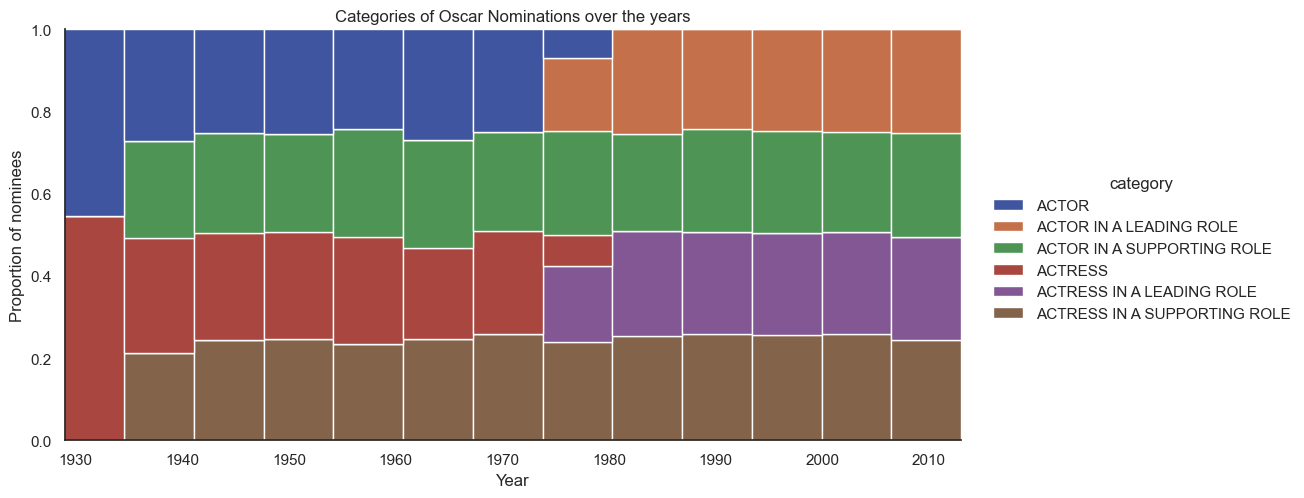

In [13]:
# Evolution of the types of Oscars Nominations given over the years
actors_oscars = actors.dropna(subset=['category'])
data = []

for cats in actors_oscars['category']:
    for film_id in cats:
        cat = cats[film_id]
        if cat[:3] == "ACT":
            movie = movies_load.query("fbID == '" + film_id + "'")
            year = movie["releaseYear"].values[0]
            data.append([year, cat])

data = pd.DataFrame(data, columns=["year", "category"])

sns.set(style="white")
sns.displot(
    data,
    x="year",
    hue="category",
    multiple="fill",
    hue_order=["ACTOR", "ACTOR IN A LEADING ROLE", "ACTOR IN A SUPPORTING ROLE", "ACTRESS", "ACTRESS IN A LEADING ROLE",
               "ACTRESS IN A SUPPORTING ROLE"],
    aspect=2,
    palette="dark",
)
plt.xlim(1929)
plt.xlabel("Year")
plt.ylabel("Proportion of nominees")
plt.title("Categories of Oscar Nominations over the years")
plt.show()

Looking at the plot, we indeed observe that the distribution of nominations among the acting categories has been consistent over time. It also confirms that the `ACTOR` / `ACTRESS` and `ACTOR IN A LEADING ROLE` / `ACTRESS IN A LEADING ROLE` are equivalent terms within the dataset. Additionally, the introduction of the supporting categories in 1937 is distinctly marked, diversifying the types of performances acknowledged by the Oscars.

Let's now explore how an actor's gender may influence their career trajectory in terms of Oscar nominations and wins.


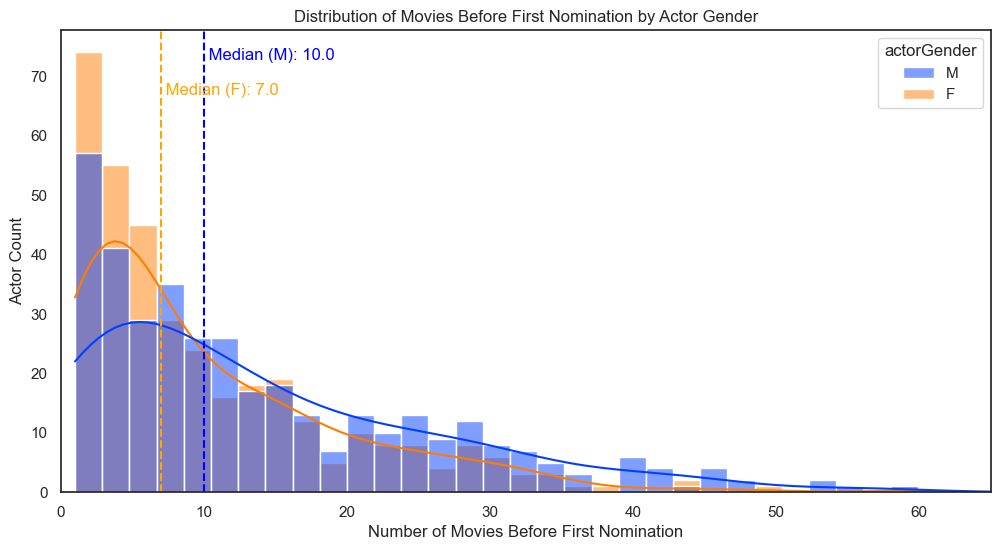

t-statistic: 4.90
p-value:     1.21e-06
There is a statistically significant discrepancy in the number of movies played before the first nomination between the two genders


In [14]:
def count_movies_before_first_nomination(winner_dict, age_dict):
    # Sort the movies by age at release
    sorted_movies_by_age = sorted(age_dict.items(), key=lambda item: item[1])

    # Find the year of the first nomination
    first_nomination_year = next(
        (age for movie_id, age in sorted_movies_by_age if movie_id in winner_dict), None)

    # Count all movies up to and including the year of the first nomination
    if first_nomination_year is not None:
        return sum(1 for _, age in sorted_movies_by_age if age <= first_nomination_year)
    else:
        return np.nan


# Count the number of movies before the first nomination for each actor that got nominated
actors['movies_before_first_nomination'] = actors.dropna(subset=('winner', 'ageAtMovieRelease')).apply(
    lambda x: count_movies_before_first_nomination(x['winner'], x['ageAtMovieRelease']), axis=1)

# Set the aesthetic style of the plots
sns.set(style="white")

plt.figure(figsize=(12, 6))
plt.xlim(0, 65)
ax = sns.histplot(data=actors, x='movies_before_first_nomination', hue='actorGender', binwidth=1.9, kde=True,
                  element='bars',
                  multiple='layer', palette='bright', legend=True)

# Compute median values for each gender and add them to the plot
median_values = actors.groupby('actorGender')['movies_before_first_nomination'].median()
plt.axvline(x=median_values['M'], linestyle='--', color='blue')
plt.text(median_values['M'], plt.ylim()[1], f'\n Median (M): {median_values["M"]:.1f}', color='blue', ha='left',
         va='top')
plt.axvline(x=median_values['F'], linestyle='--', color='orange')
plt.text(median_values['F'], plt.ylim()[1], f'\n\n\n Median (F): {median_values["F"]:.1f}', color='orange', ha='left',
         va='top')

plt.title('Distribution of Movies Before First Nomination by Actor Gender')
plt.xlabel('Number of Movies Before First Nomination')
plt.ylabel('Actor Count')

plt.show()

# Perform t-test to check if the discrepancy is significant
t_stat, p_value = ttest_ind(actors.query("actorGender == 'M'")['movies_before_first_nomination'],
                            actors.query("actorGender == 'F'")['movies_before_first_nomination'], nan_policy='omit')

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value:     {p_value:.2e}")

# Check if the difference is statistically significant at a .05 significance level
if p_value < 0.05:
    print(
        "There is a statistically significant discrepancy in the number of movies played before the first nomination between the two genders")

Considering the number of movies played before the first oscar nomination, we perform a t-test to check if there is a statistically significant difference between the means of the two groups (male and female actors). Since the p-value is below the .05 significance level, we can reject the null hypothesis and deem this discrepancy as statistically significant.

Taking a closer look at the plot, we can then infer that women tend to receive their first oscar nomination after playing fewer movies than men. This is further highlighted by the medians, showing that half of movie actresses receive their first nomination within their first 7 films, whereas actors within 10.

This disparity could suggest varying challenges and opportunities faced by actors based on gender, with potential implications for the industry's approach to gender equity. However, this may also be part of a bigger trend, so let's now shift our focus to the overall number of movies played by actors throughout their careers, by gender.


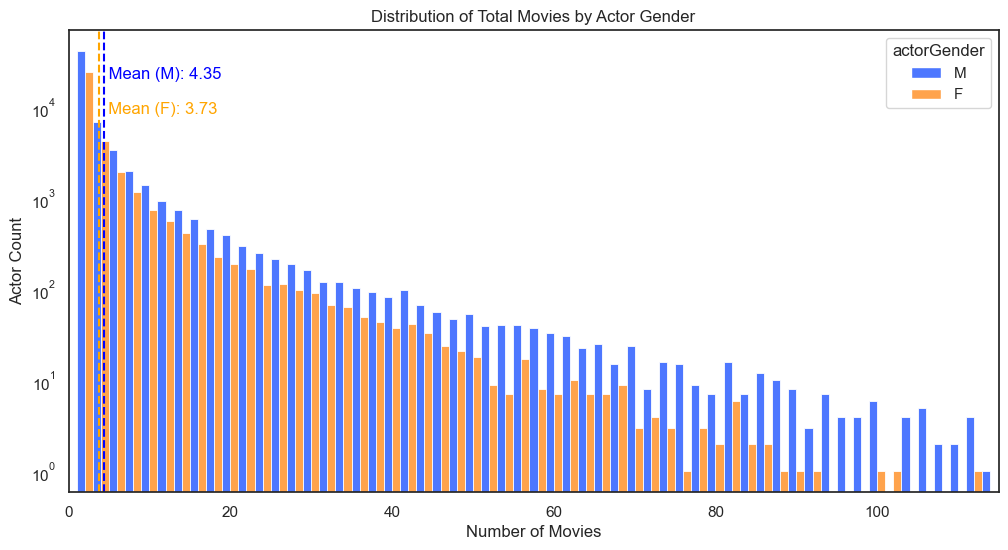

t-statistic: 10.54
p-value:     5.84e-26
There is a statistically significant discrepancy in the number of movies played between the two genders


In [15]:
plt.figure(figsize=(12, 6))
plt.xlim(0, 115)
sns.histplot(data=actors, x='numMovies', hue='actorGender', binwidth=2, element='bars', multiple='dodge',
             palette='bright', alpha=0.7, legend=True)

# Compute and display mean values
mean_values = actors.groupby('actorGender')['numMovies'].mean()
plt.axvline(x=mean_values['M'], linestyle='--', color='blue', label='mean')
plt.text(mean_values['M'], plt.ylim()[1], f'\n Mean (M): {mean_values["M"]:.2f}', color='blue', ha='left', va='top')
plt.axvline(x=mean_values['F'], linestyle='--', color='orange', label='mean')
plt.text(mean_values['F'], plt.ylim()[1], f'\n\n\n  Mean (F): {mean_values["F"]:.2f}', color='orange', ha='left',
         va='top')

plt.title('Distribution of Total Movies by Actor Gender')
plt.xlabel('Number of Movies')
plt.ylabel('Actor Count')
plt.yscale('log')
plt.show()

# Perform t-test to check if the discrepancy is significant
t_stat, p_value = ttest_ind(actors.query("actorGender == 'M'")['numMovies'],
                            actors.query("actorGender == 'F'")['numMovies'])

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value:     {p_value:.2e}")

# Check if the difference is statistically significant at a .05 significance level
if p_value < 0.05:
    print("There is a statistically significant discrepancy in the number of movies played between the two genders")

The significant statistical difference in career film counts between genders, as indicated by the t-test, raises questions about industry patterns. Male actors, on average, appear in more films than their female counterparts. This may contribute to a fiercer competition among male actors for Oscar nominations, as there is parity in annual nomination counts across gender-specific acting categories.

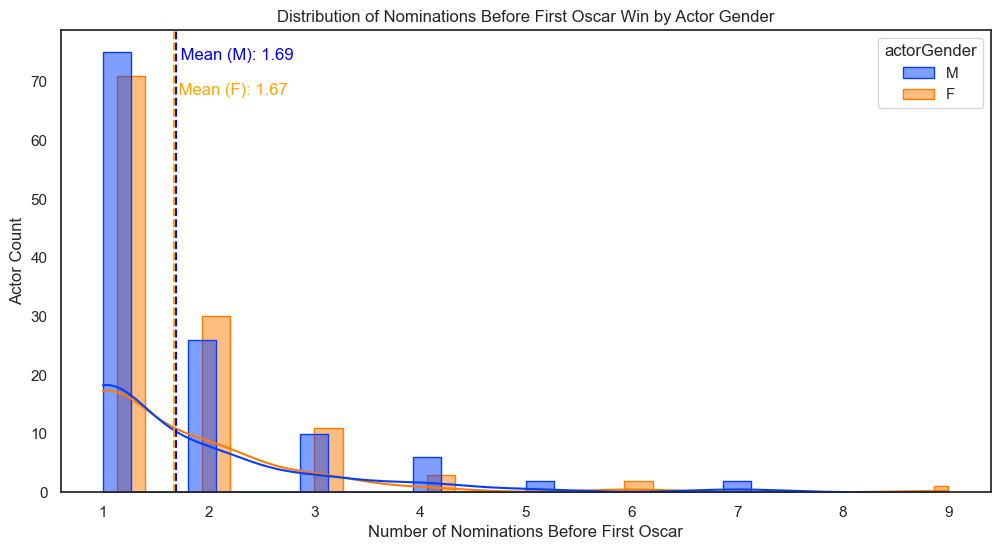

t-statistic: 0.16
p-value:     8.71e-01
There isn't a statistically significant discrepancy in the number of nominations before winning and oscar between the two genders


In [16]:
def count_nominations_before_first_win(winner_dict, age_dict):
    nominated_years = {movie_id: age_dict[movie_id] for movie_id in winner_dict if movie_id in age_dict}

    first_win_age = min(
        (nominated_years[movie_id] for movie_id, won in winner_dict.items() if won and movie_id in nominated_years),
        default=None)

    if first_win_age is not None:
        return sum(1 for age in nominated_years.values() if age <= first_win_age)
    else:
        return np.nan


actors['nominations_before_first_win'] = actors.dropna(subset=('winner', 'ageAtMovieRelease')).apply(
    lambda x: count_nominations_before_first_win(x['winner'], x['ageAtMovieRelease']), axis=1)

sns.set(style="white")

plt.figure(figsize=(12, 6))
sns.histplot(data=actors, x='nominations_before_first_win', hue='actorGender', bins=30, kde=True, element='step',
             multiple='dodge', palette='bright', legend=True)

# Display mean values
mean_values = actors.groupby('actorGender')['nominations_before_first_win'].mean()
plt.axvline(x=mean_values['M'], linestyle='--', color='blue', label='mean')
plt.text(mean_values['M'], plt.ylim()[1], f'\n Mean (M): {mean_values["M"]:.2f}', color='blue', ha='left', va='top')
plt.axvline(x=mean_values['F'], linestyle='--', color='orange', label='mean')
plt.text(mean_values['F'], plt.ylim()[1], f'\n\n\n Mean (F): {mean_values["F"]:.2f}', color='orange', ha='left',
         va='top')

plt.title('Distribution of Nominations Before First Oscar Win by Actor Gender')
plt.xlabel('Number of Nominations Before First Oscar')
plt.ylabel('Actor Count')

plt.show()

t_stat, p_value = ttest_ind(actors.query("actorGender == 'M'")['nominations_before_first_win'],
                            actors.query("actorGender == 'F'")['nominations_before_first_win'], nan_policy='omit')

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value:     {p_value:.2e}")

# Check if the difference is statistically significant at a .05 significance level
if p_value > 0.05:
    print("There isn't a statistically significant discrepancy in the number of nominations before winning and oscar between the two genders")

The histogram suggests that the journey to an Oscar win is comparably paced for both male and female actors, with average nomination counts before a win standing at 1.69 for men and 1.67 for women. A t-test confirms that there is no significant statistical discrepancy between th two genders. This was to be expected as male and female actors compete in separate categories, with the same number of annual nominations. 

Nonetheless, it is interesting to observe that the distribution of nominations before the first win follows an exponential decay, highlighting the fact that most actors only have one shot at winning an Oscar, as there are very few actors that manage to finally win after being nominated more than two times.



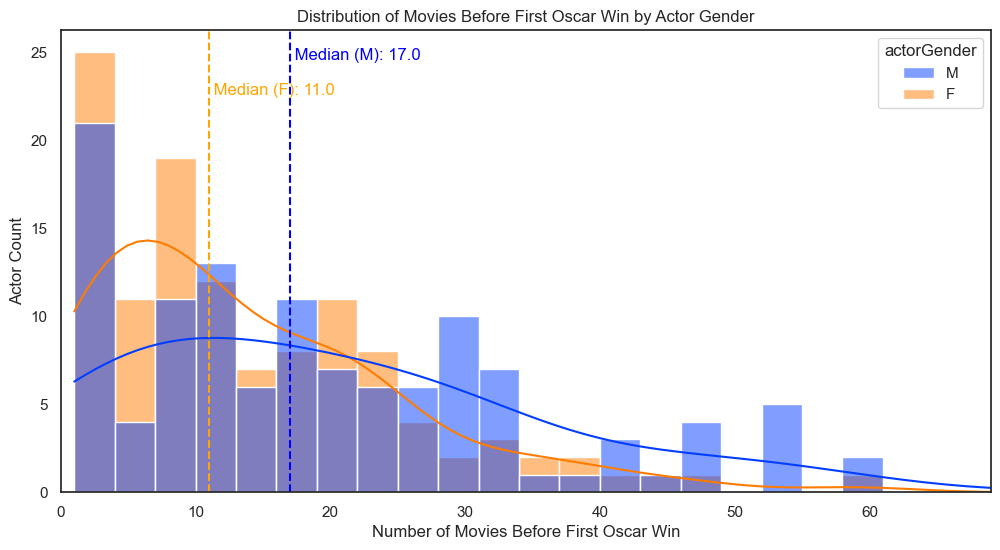

t-statistic: 3.47
p-value:     6.16e-04
There is a statistically significant discrepancy in the number of movies played before the first oscar win between the two genders


In [17]:
def count_movies_before_first_oscar_win(winner_dict, age_dict):
    # Sort the movies by age at release
    sorted_movies_by_age = sorted(age_dict.items(), key=lambda item: item[1])

    # Find the first movie where the actor won an Oscar
    first_win_index = next(
        (i for i, (movie_id, _) in enumerate(sorted_movies_by_age) if winner_dict.get(movie_id, False)), None)

    # If a win is found, return the number of movies up to and including the first win
    if first_win_index is not None:
        return first_win_index + 1
    else:
        return np.nan


# Apply the function to each row in the DataFrame
actors['movies_before_first_oscar_win'] = actors.dropna(subset=('winner', 'ageAtMovieRelease')).apply(
    lambda x: count_movies_before_first_oscar_win(x['winner'], x['ageAtMovieRelease']), axis=1)

# Set the aesthetic style of the plots
sns.set(style="white")

# Create the histogram plot
plt.figure(figsize=(12, 6))
plt.xlim(0, 69)
ax = sns.histplot(data=actors, x='movies_before_first_oscar_win', hue='actorGender', binwidth=3, kde=True,
                  element='bars',
                  multiple='layer', palette='bright', legend=True)

# Compute median values for each gender and add them to the plot
median_values = (actors.groupby('actorGender')['movies_before_first_oscar_win'].median())
plt.axvline(x=median_values['M'], linestyle='--', color='blue')
plt.text(median_values['M'], plt.ylim()[1], f'\n Median (M): {median_values["M"]:.1f}', color='blue', ha='left',
         va='top')
plt.axvline(x=median_values['F'], linestyle='--', color='orange')
plt.text(median_values['F'], plt.ylim()[1], f'\n\n\n Median (F): {median_values["F"]:.1f}', color='orange', ha='left',
         va='top')

plt.title('Distribution of Movies Before First Oscar Win by Actor Gender')
plt.xlabel('Number of Movies Before First Oscar Win')
plt.ylabel('Actor Count')

plt.show()

# Perform t-test to check if the discrepancy is significant
t_stat, p_value = ttest_ind(actors.query("actorGender == 'M'")['movies_before_first_oscar_win'],
                            actors.query("actorGender == 'F'")['movies_before_first_oscar_win'], nan_policy='omit')

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value:     {p_value:.2e}")

# Check if the difference is statistically significant at a .05 significance level
if p_value < 0.05:
    print(
        "There is a statistically significant discrepancy in the number of movies played before the first oscar win between the two genders")

blabla

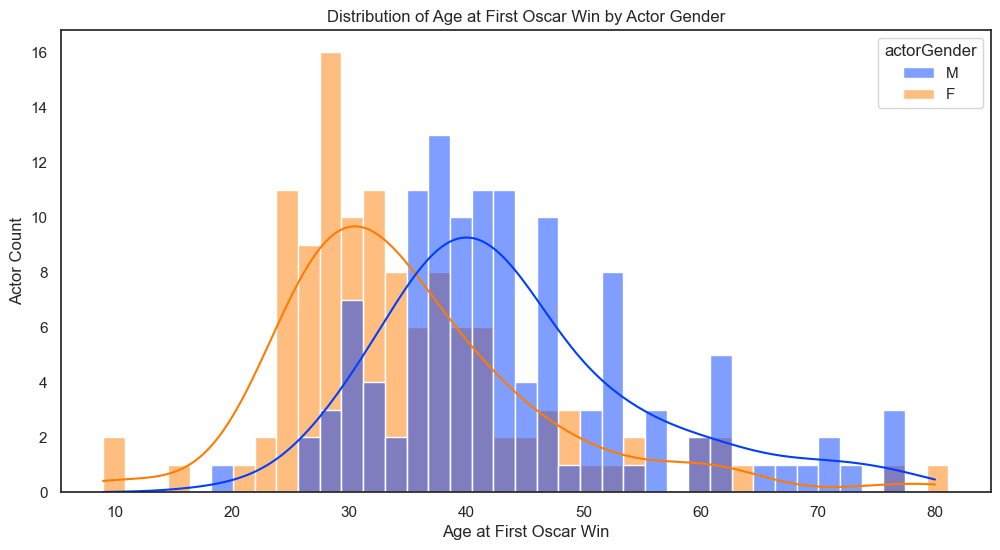

t-statistic: 6.14
p-value:     3.47e-09
There is a statistically significant discrepancy in the age when actors win their first oscar between the two genders


In [18]:
def age_at_first_oscar_win(age_dict, winner_dict):
    # Extract ages for Oscar-winning movies
    winning_ages = [age for movie_id, age in age_dict.items() if winner_dict.get(movie_id, False)]

    # Return the minimum age if there are any winning ages, else NaN
    return min(winning_ages) if winning_ages else np.nan

# Apply the function to each actor
actors['age_at_first_oscar_win'] = actors.dropna(subset=('winner', 'ageAtMovieRelease')).apply(
    lambda x: age_at_first_oscar_win(x['ageAtMovieRelease'], x['winner']), axis=1
)

plt.figure(figsize=(12, 6))
sns.histplot(data=actors, x='age_at_first_oscar_win', hue='actorGender', binwidth=1.85, kde=True, palette='bright')

plt.title('Distribution of Age at First Oscar Win by Actor Gender')
plt.xlabel('Age at First Oscar Win')
plt.ylabel('Actor Count')

plt.show()

# Perform t-test to check if the discrepancy is significant
t_stat, p_value = ttest_ind(actors.query("actorGender == 'M'")['age_at_first_oscar_win'],
                            actors.query("actorGender == 'F'")['age_at_first_oscar_win'], nan_policy='omit')

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value:     {p_value:.2e}")

# Check if the difference is statistically significant at a .05 significance level
if p_value < 0.05:
    print(
        "There is a statistically significant discrepancy in the age when actors win their first oscar between the two genders")

As we saw earlier when we looked at the actors careers, the discrepancy between the age when actors
blablu